In [2]:
# NeuronovaSim Tutorial
# A Simple Introduction to Spiking Neural Networks with NeuronovaSim

import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Import necessary components from your library
from Neuronova_Sim.NeuronovaSim import NeuronovaSim

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

device is cpu
******************************************************


100%|██████████| 100/100 [00:30<00:00,  3.32it/s]

Mean L1-loss: 2.16e-01
Mean rel. err.: 4.47e+00


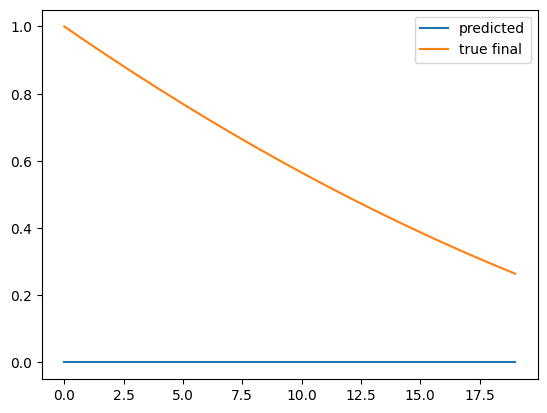

In [ ]:
class PolyRegressionDataset(Dataset):
    """Generates time-series inputs x_t = linspace(0,end) and targets y_t = a*x_t^2 + b*x_t + c"""

    def __init__(self, timesteps, num_samples, a, b, c):
        self.timesteps = timesteps
        ends = torch.rand(num_samples, 1)
        features = []
        for end in ends:
            seq = torch.linspace(0.0, float(end), steps=timesteps).view(timesteps, 1)
            features.append(seq)
        # shape (num_samples, time, 1)
        self.inputs = torch.stack(features, dim=0)
        # compute polynomial targets (same shape)
        x = self.inputs
        self.targets = a * x**2 + b * x + c

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        # return (time, features)
        x = self.inputs[idx]  # (T,1)
        y = self.targets[idx]  # (T,1)
        return x, y


# 2. Define SNN regression model using NeuronovaSim
class SNNRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # two-layer SNN: hidden -> output
        neurons_per_layer = [hidden_size, output_size]
        self.sim = NeuronovaSim(
            chip_topoplogy="tmp",
            chip_model="LIF",
            input_size=input_size,
            neuron_number_per_layer=neurons_per_layer,
            device="cpu",
        )

    def forward(self, x):
        # x: (batch, time, features)
        x_norm = (x - x.min()) / (x.max() - x.min() + 1e-8)
        # simulator returns (time, batch, features) tuples: spikes & states
        spk0, spk1, spk2, mem0, mem1, mem2, cur0, cur1, cur2 = self.sim.forward(x_norm)
        # output spikes spk2: (time, batch, output_size)
        spk_out = spk2.permute(1, 0, 2)  # (batch, time, output_size)
        # sum over time to get regression output: (batch, output_size)
        out = spk_out.sum(dim=1)
        return out  # shape (batch, output_size)


# 3. Training & evaluation


def train(model, loader, num_iter=100, lr=1e-3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    hist = []
    for _ in trange(num_iter):
        for x, y in loader:
            # x,y: (batch, time, features)
            opt.zero_grad()
            preds = model(x)
            # y_target: final time-step value (batch, features)
            y_target = y[:, -1, :]
            loss = loss_fn(preds, y_target)
            loss.backward()
            opt.step()
            hist.append(loss.item())
    return hist


def evaluate(model, loader):
    l1_fn = nn.L1Loss()
    rels, l1s = [], []
    with torch.no_grad():
        for x, y in loader:
            preds = model(x)
            y_target = y[:, -1, :]
            l1 = l1_fn(preds, y_target)
            rel = torch.mean(
                torch.norm(preds - y_target, dim=-1) / torch.norm(y_target, dim=-1)
            )
            l1s.append(l1.item())
            rels.append(rel.item())
    return statistics.mean(l1s), statistics.mean(rels)


# 4. Run experiment
if __name__ == "__main__":
    # polynomial coefficients
    a, b, c = 2.0, -3.0, 1.0
    T, N, batch_size = 20, 100, 1
    ds = PolyRegressionDataset(T, N, a, b, c)
    loader = DataLoader(ds, batch_size=batch_size)

    model = SNNRegressor(input_size=1, hidden_size=32, output_size=T)
    loss_hist = train(model, loader, num_iter=100)
    mean_l1, mean_rel = evaluate(model, loader)
    print(f"Mean L1-loss: {mean_l1:.2e}")
    print(f"Mean rel. err.: {mean_rel:.2e}")

    # plot one example
    x, y = next(iter(loader))
    preds = model(x)
    plt.plot(preds.squeeze().detach().numpy(), label="predicted")
    plt.plot(y[-1, :, 0].numpy(), label="true final")
    plt.legend()
    plt.show()

In [14]:
preds.squeeze()

tensor(0., grad_fn=<SqueezeBackward0>)